 master-thesisInput:
- True Observations
- Number Training Steps

Output:
- New Model Parameter

Parts of Optimization:
- Initialization of Model Parameter
- tbd

# Initialization

## Import Libraries and Mount Drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import distributions, optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/master-thesis


In [3]:
#%cd ..

In [4]:
from model.methods import *
from model.modelcore import epid_model
from model.modelhelper import *

## Optimization Settings

In [5]:
observation = 'newly_infected' #'newly_infected' #'hospitalization'
rolling_avg_obs = 2
# Overall Time Period
start_time='2020-06-15' 
end_time='2021-02-15' # Begin Delta Wave

# Training Time Period
start_time_train=start_time
end_time_train='2021-01-15'

#Test Time Period
start_time_test='2020-01-16'
end_time_test=end_time

dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #cuda:0

## Initialize Observations

In [6]:
df_obs_initial = pd.read_csv('data/220309_observations.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])

# Initialize Observations Training
df_obs_train, initial_newly_infected_train = initialize_observations(df_obs_initial, start=start_time_train, end=end_time_train, rolling_avg=rolling_avg_obs)
observed_train = torch.tensor(df_obs_train[observation], requires_grad=False, device=device, dtype=dtype)

# Initialize Observations Testing
df_obs_test, initial_newly_infected_test = initialize_observations(df_obs_initial, start=start_time_test, end=end_time_test, rolling_avg=rolling_avg_obs)
observed_test = torch.tensor(df_obs_test[observation], requires_grad=False, device=device, dtype=dtype)

# Create df_obs
df_obs = pd.concat([df_obs_train, df_obs_test])

df_obs.head(3)

,Date,number_of_deaths,newly_infected,hospitalization
0,2020-06-15,0.5,29.5,1.5
1,2020-06-16,0.5,42.0,4.5
2,2020-06-17,1.0,59.5,6.0


In [7]:
#for column in df_obs.columns:
#  plt.plot(df_obs['Date'], df_obs[column])
#  plt.title(column)
#  plt.show()

## Initialize Model Parameter

### Initialize helper parameter

In [8]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
#num_observations = df_obs.shape[0]
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)

### Initialize method parameter

In [9]:
method = TwoClusterLinear(device=device, dtype=dtype)

### Initialize alpha and phi

In [10]:
dict_param = initialize_parameter(['alpha', 'phi'], device, dtype)
dict_param

{'prime_values': {'alpha': tensor(-0.0746, requires_grad=True),
  'phi': tensor(-0., requires_grad=True)},
 'real_values': {'alpha': tensor(0.0100, grad_fn=<AddBackward0>),
  'phi': tensor(25., grad_fn=<AddBackward0>)}}

## Load Method Input Data

In [11]:
method.set_cluster_train(start_time_train, end_time_train)
method.set_cluster_test(start_time_test, end_time_test)

# Optimization

## Training

Step: 0, Learning Rate: 0.00999 Time: 0.2007, Training Comparison Loss: 1579748.875, Test Comparison Loss: 3321388.25


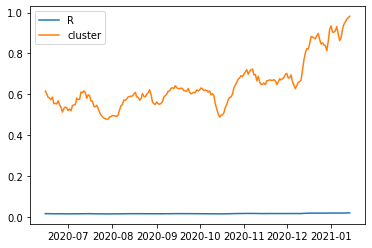

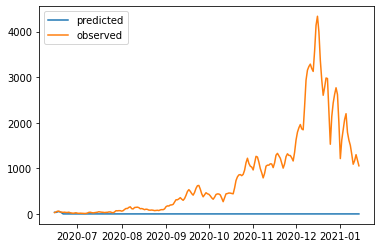

Step: 50, Learning Rate: 0.00950254422568834 Time: 0.1842, Training Comparison Loss: 1574483.75, Test Comparison Loss: 1926469.25


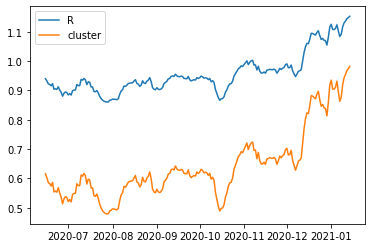

Step: 100, Learning Rate: 0.009038873549665948 Time: 0.1009, Training Comparison Loss: 755597.25, Test Comparison Loss: 67175632.0


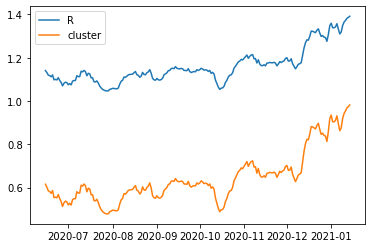

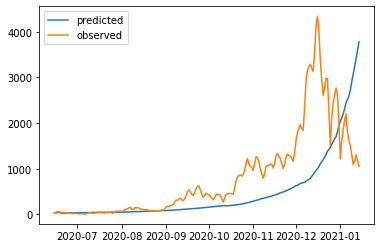

Step: 150, Learning Rate: 0.008597827393003531 Time: 0.0975, Training Comparison Loss: 736581.75, Test Comparison Loss: 57435120.0


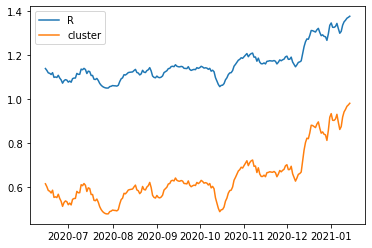

Step: 200, Learning Rate: 0.008178301806491574 Time: 0.1027, Training Comparison Loss: 714121.125, Test Comparison Loss: 49354692.0


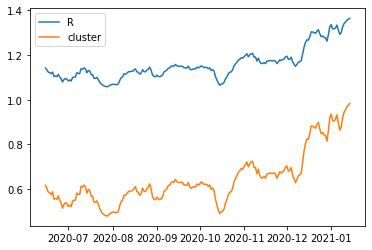

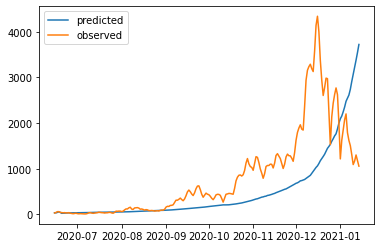

Step: 250, Learning Rate: 0.00777924670742873 Time: 0.099, Training Comparison Loss: 688744.25, Test Comparison Loss: 41842496.0


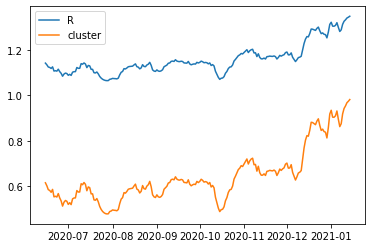

Step: 300, Learning Rate: 0.007399663251239432 Time: 0.1165, Training Comparison Loss: 660796.5, Test Comparison Loss: 34891972.0


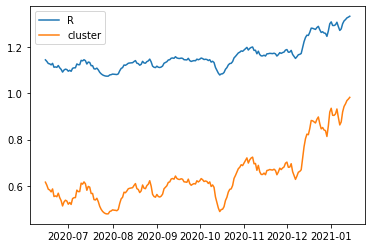

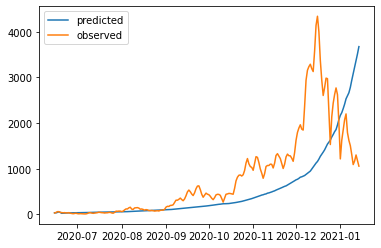

Step: 350, Learning Rate: 0.007038601331341688 Time: 0.1279, Training Comparison Loss: 630615.3125, Test Comparison Loss: 28679118.0


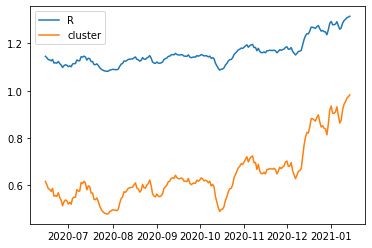

Step: 400, Learning Rate: 0.006695157201007331 Time: 0.1041, Training Comparison Loss: 598565.75, Test Comparison Loss: 23276220.0


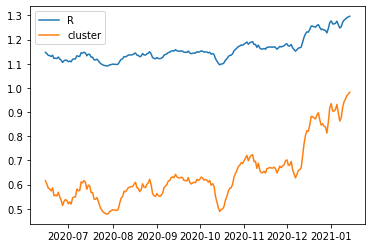

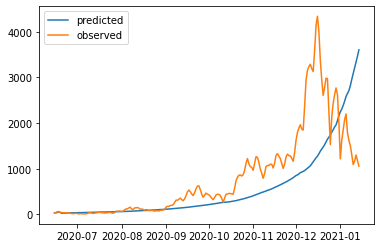

Step: 450, Learning Rate: 0.006368471211262053 Time: 0.1029, Training Comparison Loss: 565069.5625, Test Comparison Loss: 18690228.0


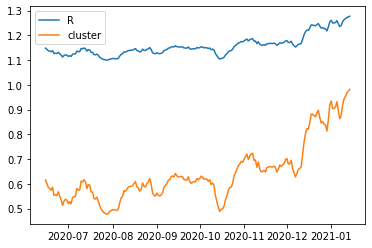

Step: 500, Learning Rate: 0.006057725659163231 Time: 0.1021, Training Comparison Loss: 530617.1875, Test Comparison Loss: 14881453.0


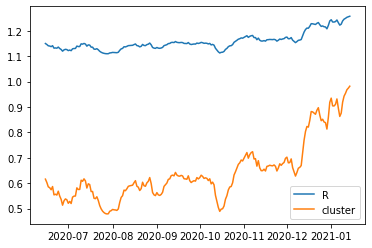

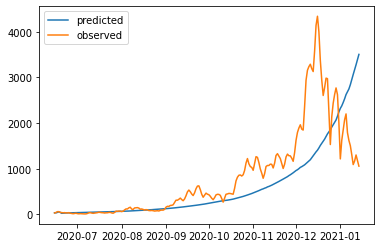

Step: 550, Learning Rate: 0.0057621427410696376 Time: 0.3848, Training Comparison Loss: 495766.21875, Test Comparison Loss: 11779812.0


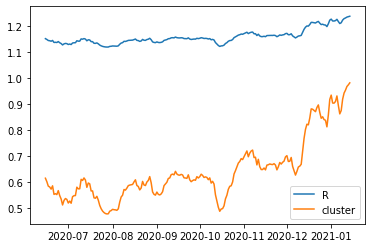

Step: 600, Learning Rate: 0.005480982605780108 Time: 0.0981, Training Comparison Loss: 461125.6875, Test Comparison Loss: 9298590.0


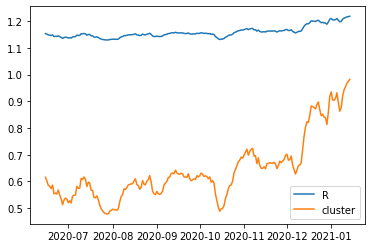

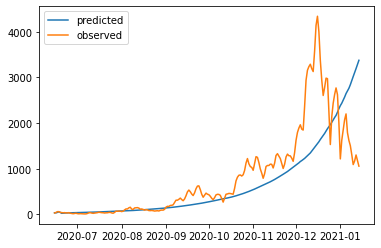

Step: 650, Learning Rate: 0.005213541502668067 Time: 0.0984, Training Comparison Loss: 427323.5, Test Comparison Loss: 7344955.0


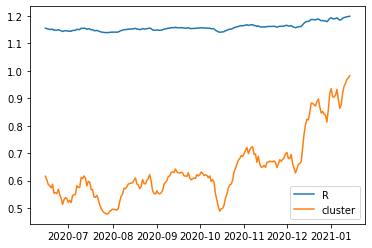

Step: 700, Learning Rate: 0.004959150020176671 Time: 0.1037, Training Comparison Loss: 394964.3125, Test Comparison Loss: 5827862.5


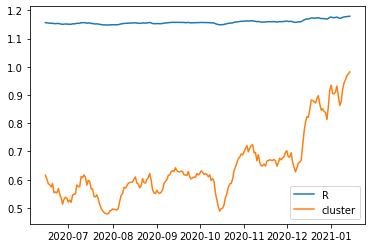

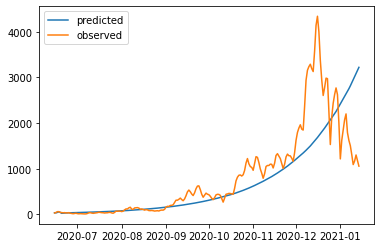

Step: 750, Learning Rate: 0.004717171410265472 Time: 0.0989, Training Comparison Loss: 364582.8125, Test Comparison Loss: 4663490.5


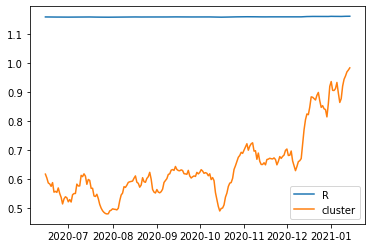

Step: 800, Learning Rate: 0.004486999994614646 Time: 0.101, Training Comparison Loss: 336603.25, Test Comparison Loss: 3778338.5


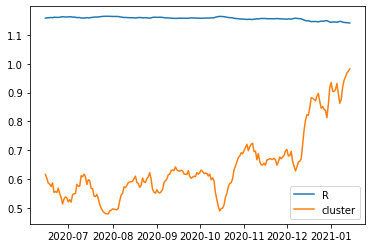

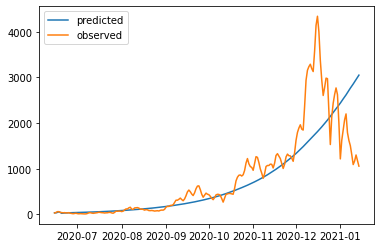

Step: 850, Learning Rate: 0.004268059648597501 Time: 0.1146, Training Comparison Loss: 311311.75, Test Comparison Loss: 3110301.5


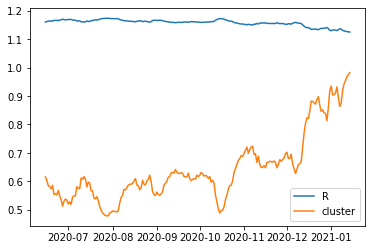

Step: 900, Learning Rate: 0.0040598023592265855 Time: 0.1082, Training Comparison Loss: 288845.71875, Test Comparison Loss: 2608712.0


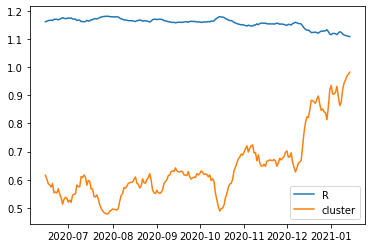

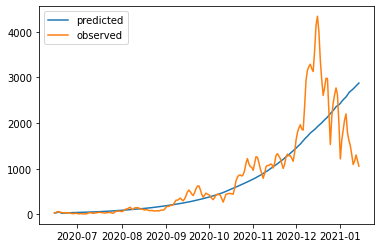

Step: 950, Learning Rate: 0.0038617068534639145 Time: 0.1064, Training Comparison Loss: 269205.6875, Test Comparison Loss: 2233258.25


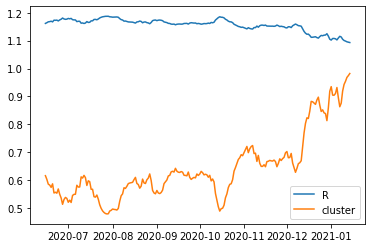

Step: 1000, Learning Rate: 0.0036732772934619236 Time: 0.1037, Training Comparison Loss: 252276.390625, Test Comparison Loss: 1952552.75


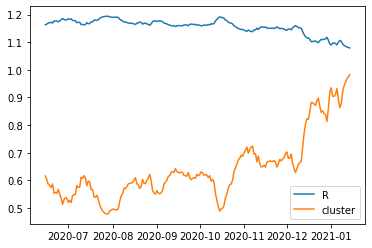

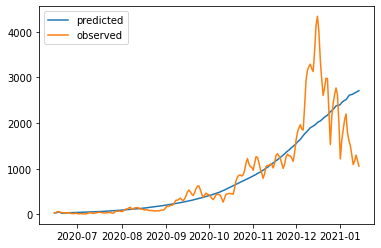

Step: 1050, Learning Rate: 0.00349404203546934 Time: 0.0994, Training Comparison Loss: 237859.703125, Test Comparison Loss: 1742617.5


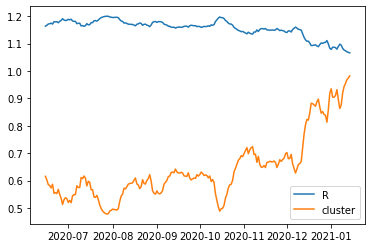

Step: 1100, Learning Rate: 0.0033235524492954472 Time: 0.1063, Training Comparison Loss: 225706.375, Test Comparison Loss: 1585346.25


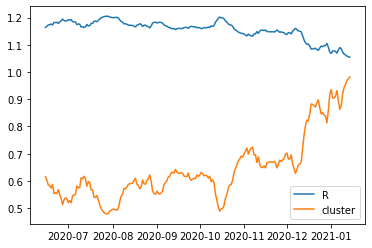

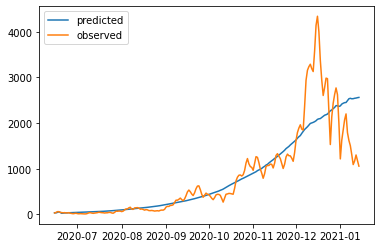

Step: 1150, Learning Rate: 0.0031613817953778573 Time: 0.1052, Training Comparison Loss: 215544.703125, Test Comparison Loss: 1467217.375


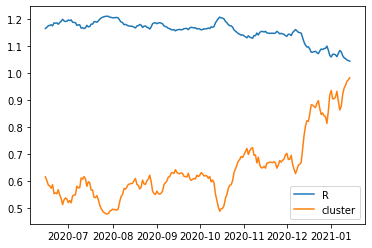

Step: 1200, Learning Rate: 0.0030071241566430543 Time: 0.101, Training Comparison Loss: 207102.734375, Test Comparison Loss: 1378180.625


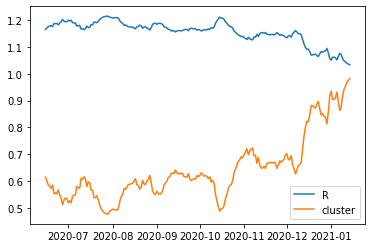

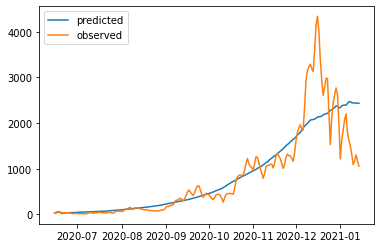

Step: 1250, Learning Rate: 0.0028603934224861256 Time: 0.0986, Training Comparison Loss: 200122.84375, Test Comparison Loss: 1310806.0


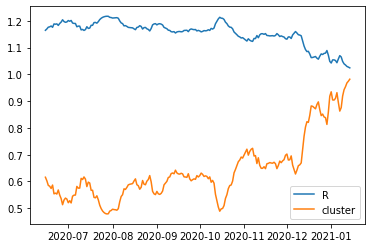

Step: 1300, Learning Rate: 0.0027208223223265725 Time: 0.1026, Training Comparison Loss: 194371.609375, Test Comparison Loss: 1259610.125


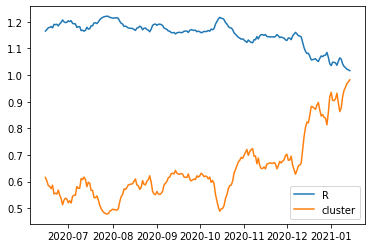

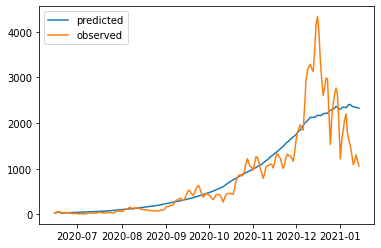

Step: 1350, Learning Rate: 0.002588061506321153 Time: 0.1034, Training Comparison Loss: 189643.125, Test Comparison Loss: 1220536.125


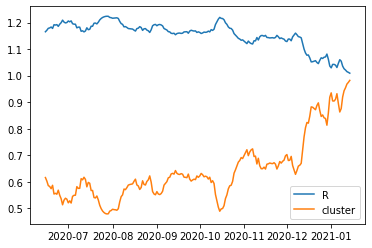

Step: 1400, Learning Rate: 0.002461778670932766 Time: 0.1014, Training Comparison Loss: 185760.203125, Test Comparison Loss: 1190582.25


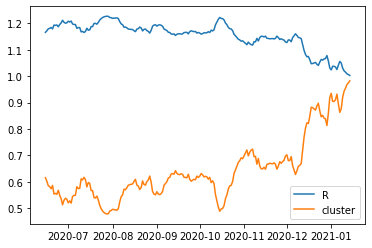

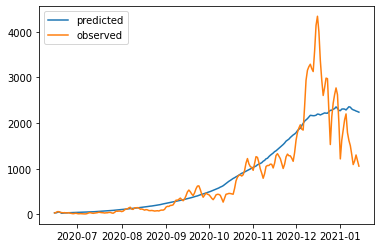

Step: 1450, Learning Rate: 0.0023416577271666533 Time: 0.1106, Training Comparison Loss: 182572.796875, Test Comparison Loss: 1167519.875


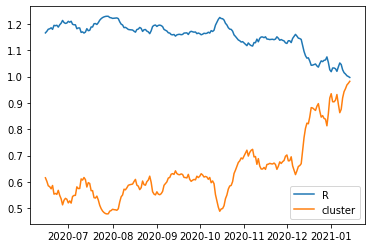

Step: 1500, Learning Rate: 0.0022273980093919887 Time: 0.0984, Training Comparison Loss: 179955.515625, Test Comparison Loss: 1149692.0


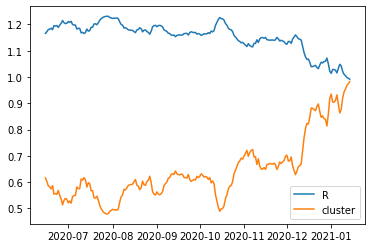

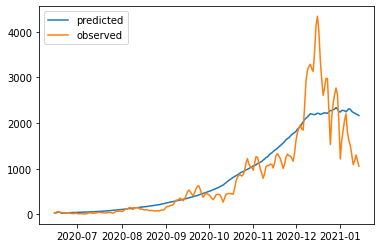

Step: 1550, Learning Rate: 0.0021187135227685237 Time: 0.0986, Training Comparison Loss: 177804.28125, Test Comparison Loss: 1135854.875


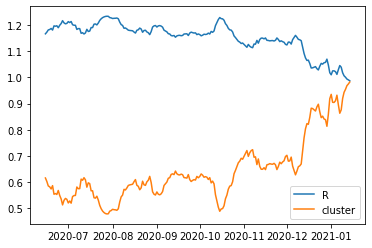

Step: 1600, Learning Rate: 0.002015332227394579 Time: 0.1004, Training Comparison Loss: 176033.90625, Test Comparison Loss: 1125077.75


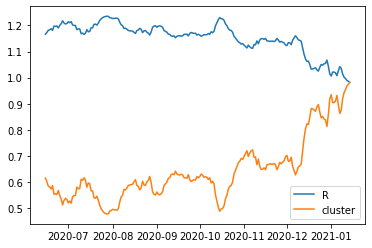

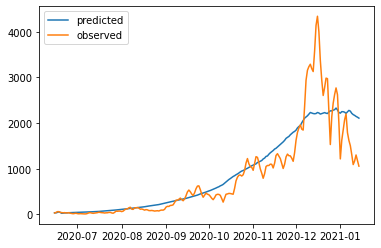

Step: 1650, Learning Rate: 0.0019169953573845828 Time: 0.116, Training Comparison Loss: 174574.390625, Test Comparison Loss: 1116655.875


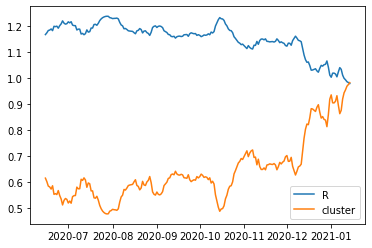

Step: 1700, Learning Rate: 0.0018234567731717946 Time: 0.1023, Training Comparison Loss: 173368.6875, Test Comparison Loss: 1110055.5


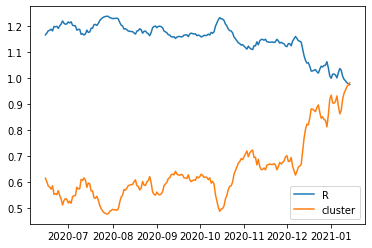

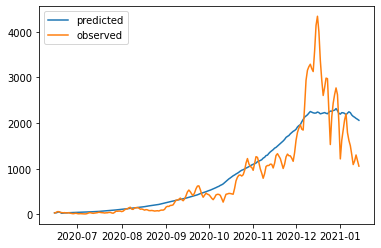

Step: 1750, Learning Rate: 0.0017344823454150087 Time: 0.1072, Training Comparison Loss: 172370.46875, Test Comparison Loss: 1104869.625


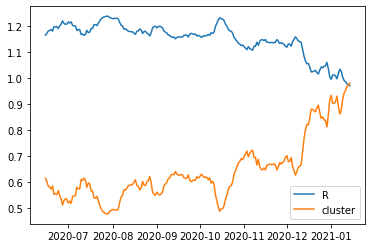

Step: 1800, Learning Rate: 0.0016498493689671438 Time: 0.107, Training Comparison Loss: 171542.015625, Test Comparison Loss: 1100786.625


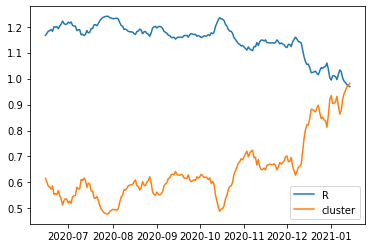

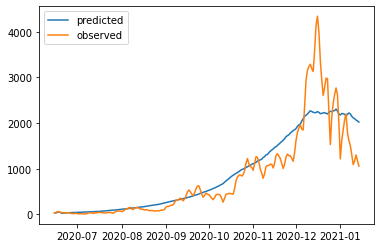

Step: 1850, Learning Rate: 0.0015693460054388676 Time: 0.1006, Training Comparison Loss: 170852.6875, Test Comparison Loss: 1097567.0


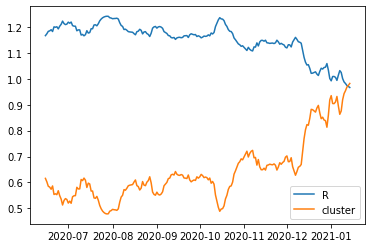

Step: 1900, Learning Rate: 0.0014927707529619797 Time: 0.11, Training Comparison Loss: 170277.640625, Test Comparison Loss: 1095025.25


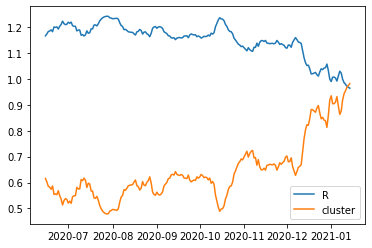

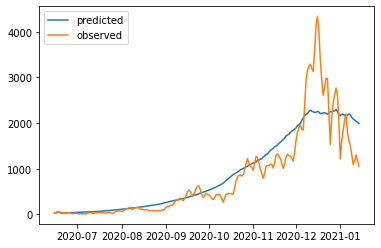

Step: 1950, Learning Rate: 0.0014199319418253553 Time: 0.1075, Training Comparison Loss: 169796.515625, Test Comparison Loss: 1093018.25


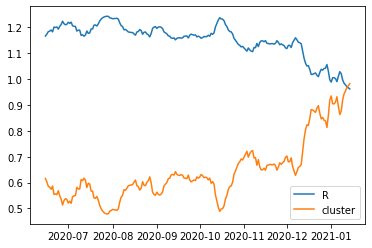

In [12]:
from torch.optim.lr_scheduler import ExponentialLR

epochs = 500
model_parameter = [dict_param['prime_values']['alpha'], dict_param['prime_values']['phi']]

params_to_be_optimized = method.get_parameters() #+ [dict_param['prime_values']['phi']]
if observation == 'hospitalization':
  params_to_be_optimized = params_to_be_optimized + [dict_param['prime_values']['alpha']]

optimizer = optim.Adam(params_to_be_optimized, lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.999)

for i in range(epochs):
  start_time = time.time()
  optimizer.zero_grad()

  # transform alphi, phi
  transform_prime_variables(dict_param)

  # forward pass
  expected = epid_model(population, R=method.calculate_R(method.cluster_percentage_train), initial_newly_infected = initial_newly_infected_train, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
  
  # calc loss
  comparison_loss_train =  calc_mse(expected, observed_train) #* dict_param['real_values']['phi']
  method_loss = method.calculate_loss()
  model_param_loss = calc_prior_loss(dict_param, device, dtype)
  loss = comparison_loss_train + method_loss + model_param_loss

  # backward pass
  loss.backward()
  optimizer.step()
  scheduler.step()
  
  
  with torch.no_grad():
    if i % 50==0:
        current_time = round((time.time() - start_time),4)
        current_lr = optimizer.state_dict()['param_groups'][0]['lr']
        expected_test = epid_model(population, R=method.calculate_R(method.cluster_percentage_test), initial_newly_infected = initial_newly_infected_test, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
        print(f'Step: {i}, Learning Rate: {current_lr} Time: {current_time}, Training Comparison Loss: {comparison_loss_train}, Test Comparison Loss: {calc_mse(expected_test, observed_test)}')
        plt.plot(df_obs_train['Date'], method.calculate_R(method.cluster_percentage_train).cpu().detach().numpy(), label='R')
        plt.plot(df_obs_train['Date'], method.cluster_percentage_train, label='cluster')
        plt.legend()
        plt.show()
    if i % 100==0:
      #print(method.calculate_R(cluster_percentage))
      plt.plot(df_obs_train['Date'], expected.cpu().detach().numpy(), label='predicted')
      plt.plot(df_obs_train['Date'], observed_train.cpu().detach().numpy(), label='observed')
      plt.legend()
      plt.show()


# Evaluation

## Train and Test Time 

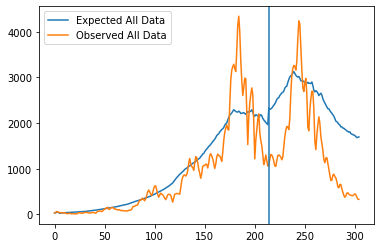

In [15]:
cluster_percentage_train_test = np.concatenate((method.cluster_percentage_train, method.cluster_percentage_test), axis=None)
expected_train_test = epid_model(population, R=method.calculate_R(cluster_percentage_train_test), initial_newly_infected = initial_newly_infected_train, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
observed_train_test = torch.concat((observed_train, observed_test))

plt.plot(expected_train_test.cpu().detach().numpy(),label='Expected All Data')
plt.plot(observed_train_test.cpu().detach().numpy(),label='Observed All Data')
plt.axvline(x=observed_train.shape[0])
plt.legend()
plt.show()

## Eval on Test Data

Comparison Loss Train: 169400.390625 - Comparison Loss Test: 27286518.0


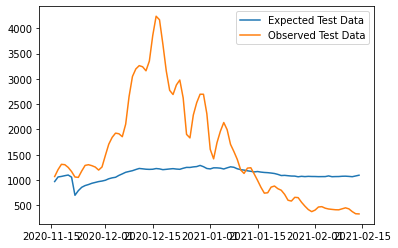

In [16]:
expected_test = epid_model(population, R=method.calculate_R(method.cluster_percentage_test), initial_newly_infected = initial_newly_infected_test, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
comparison_loss_test = calc_mse(expected_test, observed_test) * dict_param['real_values']['phi']
print(f'Comparison Loss Train: {comparison_loss_train} - Comparison Loss Test: {comparison_loss_test}')

plt.plot(df_obs_test['Date'], expected_test.cpu().detach().numpy(),label='Expected Test Data')
plt.plot(df_obs_test['Date'], observed_test.cpu().detach().numpy(),label='Observed Test Data')
plt.legend()
plt.show()

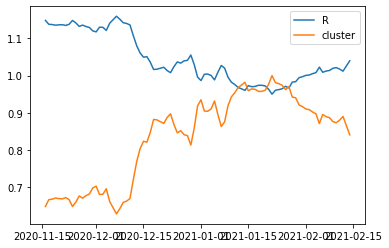

In [17]:
# Plot R-Value & Cluster Percentage
plt.plot(df_obs_test['Date'], method.calculate_R(method.cluster_percentage_test).cpu().detach().numpy(), label='R')
plt.plot(df_obs_test['Date'], method.cluster_percentage_test, label='cluster')
plt.legend()
plt.show()

## Eval What IF

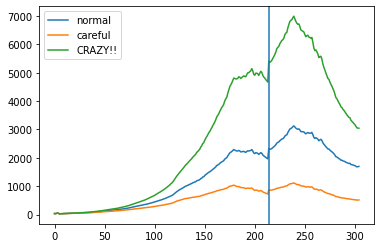

In [18]:
expected_normal = epid_model(population, R=method.calculate_R(cluster_percentage_train_test), initial_newly_infected = initial_newly_infected_train, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
expected_careful= epid_model(population, R=method.calculate_R(cluster_percentage_train_test*1.1), initial_newly_infected = initial_newly_infected_train, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
expected_crazy = epid_model(population, R=method.calculate_R(cluster_percentage_train_test*0.9), initial_newly_infected = initial_newly_infected_train, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]

plt.plot(expected_normal.cpu().detach().numpy(),label='normal')
plt.plot(expected_careful.cpu().detach().numpy(),label='careful')
plt.plot(expected_crazy.cpu().detach().numpy(),label='CRAZY!!')
plt.axvline(x=observed_train.shape[0])
plt.legend()
plt.show()

## Eval Cluster Percentage vs R-Value

Slope: -0.563510230820315, intercept: 1.5135800128520807, r-squared: 0.999999999999871


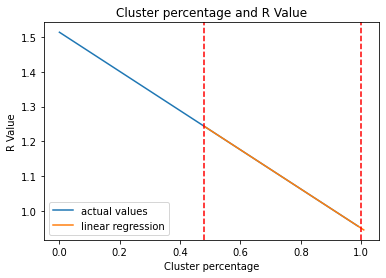

In [19]:
from scipy import stats

x = np.arange(0,1 , 0.01)
y = np.squeeze(method.calculate_R(x).cpu().detach().numpy())


x_min = cluster_percentage_train_test.min()
x_max = cluster_percentage_train_test.max()
x_bound = np.arange(x_min, x_max + 0.01 , 0.01)
y_bound = np.squeeze(method.calculate_R(x_bound).cpu().detach().numpy())

slope, intercept, r_value, p_value, std_err = stats.linregress(x_bound, y_bound)
y_linreg = intercept + slope * x_bound
print(f'Slope: {slope}, intercept: {intercept}, r-squared: {r_value**2}')
plt.plot(x, y, label='actual values')
plt.plot(x_bound, y_linreg, label='linear regression')
plt.axvline(x=x_min, c='r', linestyle='--')
plt.axvline(x=x_max, c='r', linestyle='--')
plt.xlabel('Cluster percentage')
plt.ylabel('R Value')
plt.title('Cluster percentage and R Value')
plt.legend()
plt.show()